
# kaggleのデータセットを用いてモデルを構築する

### 目的：住宅価格を予測する
###  URL:https://www.kaggle.com/c/house-prices-advanced-regression-techniques


In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso
)
# 警告非表示
import warnings
warnings.filterwarnings('ignore')

In [24]:
# データの読み込み
train = pd.read_csv('./train.csv') #訓練データ
test = pd.read_csv('./test.csv') #テストデータ

# 学習データとテストデータのマージ
train['WhatIsData'] = 'Train'
test['WhatIsData'] = 'Test'
test['SalePrice'] = 9999999999

alldata = pd.concat([train,test],axis=0).reset_index(drop=True)

print('The size of train is : ' + str(train.shape))
print('The size of test is : ' + str(test.shape))

# 学習データの欠損状況
print('\n ▼ 学習データの欠損状況 ')
print(train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending=False))

# テストデータの欠損状況
print('\n ▼ テストデータの欠損状況 ')
print(test.isnull().sum()[test.isnull().sum()>0].sort_values(ascending=False))

# 欠損を含むカラムのリスト表示
na_col_list = alldata.isnull().sum()[alldata.isnull().sum()>0].index.tolist() 
print('\n ▼ 欠損を含むカラムの型リスト表示 ')
print(alldata[na_col_list].dtypes.sort_values()) 

The size of train is : (1460, 82)
The size of test is : (1459, 82)

 ▼ 学習データの欠損状況 
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

 ▼ テストデータの欠損状況 
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exter

In [25]:
# floatの場合は0
# objectの場合は'NA'
na_float_cols = alldata[na_col_list].dtypes[alldata[na_col_list].dtypes=='float64'].index.tolist() #float64
na_obj_cols = alldata[na_col_list].dtypes[alldata[na_col_list].dtypes=='object'].index.tolist() #object

# float64型で欠損している場合は0を代入
for na_float_col in na_float_cols:
    alldata.loc[alldata[na_float_col].isnull(),na_float_col] = 0.0
    
# object型で欠損している場合は'NA'を代入
for na_obj_col in na_obj_cols:
    alldata.loc[alldata[na_obj_col].isnull(),na_obj_col] = 'NA'

# 欠損を含むカラムのリスト表示
na_col_list = alldata.isnull().sum()[alldata.isnull().sum()>0].index.tolist() 
print('\n ▼ 欠損を含むカラムの型リスト表示 ')
print(alldata[na_col_list].dtypes.sort_values()) 


 ▼ 欠損を含むカラムの型リスト表示 
Series([], dtype: object)


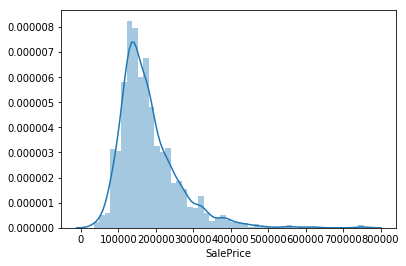

In [26]:
# カテゴリカル変数の特徴量をリスト化
cat_cols = alldata.dtypes[alldata.dtypes=='object'].index.tolist()
# 数値変数の特徴量をリスト化
num_cols = alldata.dtypes[alldata.dtypes!='object'].index.tolist()
# データ分割および提出時に必要なカラムをリスト化
other_cols = ['Id','WhatIsData']
# 余計な要素をリストから削除
cat_cols.remove('WhatIsData') #学習データ・テストデータ区別フラグ除去
num_cols.remove('Id') #Id削除
# カテゴリカル変数をダミー化
alldata_cat = pd.get_dummies(alldata[cat_cols])
# データ統合
all_data = pd.concat([alldata[other_cols],alldata[num_cols],alldata_cat],axis=1)

sns.distplot(train['SalePrice'])


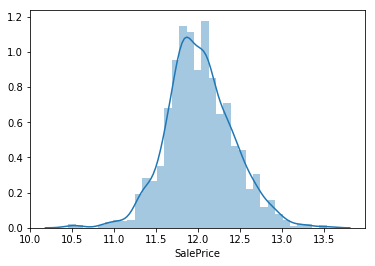

In [27]:
# 対数変換
sns.distplot(np.log(train['SalePrice']))

In [28]:
# マージデータを学習データとテストデータに分割
train_ = all_data[all_data['WhatIsData']=='Train'].drop(['WhatIsData','Id'], axis=1).reset_index(drop=True)
test_ = all_data[all_data['WhatIsData']=='Test'].drop(['WhatIsData','SalePrice'], axis=1).reset_index(drop=True)
# 学習データ内の分割
train_x = train_.drop('SalePrice',axis=1)
train_y = np.log(train_['SalePrice'])
# テストデータ内の分割
test_id = test_['Id']
test_data = test_.drop('Id',axis=1)

In [31]:
scaler = StandardScaler()  #スケーリング
param_grid = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] #パラメータグリッド
cnt = 0
for alpha in param_grid:
    ls = Lasso(alpha=alpha) #Lasso回帰モデル
    pipeline = make_pipeline(scaler, ls) #パイプライン生成
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)
    pipeline.fit(X_train,y_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
    test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))
    if cnt == 0:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    elif best_score > test_rmse:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    else:
        pass
    cnt = cnt + 1
    
print('alpha : ' + str(best_param))
print('test score is : ' +str(best_score))

alpha : 0.01
test score is : 0.18073690872149373


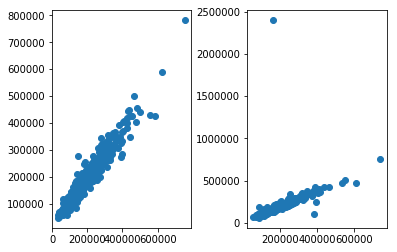

In [32]:
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.scatter(np.exp(y_train),np.exp(best_estimator.predict(X_train)))
plt.subplot(122)
plt.scatter(np.exp(y_test),np.exp(best_estimator.predict(X_test)))

In [34]:
# test_id
ls = Lasso(alpha = 0.01)
pipeline = make_pipeline(scaler, ls)
pipeline.fit(train_x,train_y)
test_SalePrice = pd.DataFrame(np.exp(pipeline.predict(test_data)),columns=['SalePrice'])
test_Id = pd.DataFrame(test_id,columns=['Id'])
pd.concat([test_Id, test_SalePrice],axis=1).to_csv('./output.csv',index=False)